# HMMs and Viterbi algorithm for POS tagging ASSIGNMENT.
## This assignment focuses on
## 1. Modifying the Vanilla Viterbi to get good accuracy for unknown words using any 2 approaches.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#Importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re,nltk
from nltk.tokenize import word_tokenize
import pprint, time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import sent_tokenize


### Data Preparation

In [ ]:
nltk.download()


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> D

Download which package (l=list; x=cancel)?
  Identifier> L
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [

True

In [4]:
nltk.download('universal_tagset')
nltk.download('treebank')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [7]:
type(nltk_data[0])
nltk_data[0]

[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('board', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('nonexecutive', 'ADJ'),
 ('director', 'NOUN'),
 ('Nov.', 'NOUN'),
 ('29', 'NUM'),
 ('.', '.')]

In [5]:
train_set,test_set = train_test_split(nltk_data,test_size=0.05,random_state=20)

In [6]:
print(len(train_set),len(test_set))

3718 196


In [8]:
train_tagged_words = [tup for sent in train_set for tup in sent]
train_vocab = [pair[0] for pair in train_tagged_words]
train_pos = [pair[1] for pair in train_tagged_words]
train_vocab_set = set(train_vocab)
train_pos_set = set(train_pos)


In [9]:
print(train_vocab_set,train_pos_set)

{'Peters', 'trailed', '87-store', 'concede', 'default', 'century', 'buy-out', 'waterworks', 'source', 'predictably', 'industrials', 'Suisse', 'bank', 'For', '4.898', 'Burgundies', 'stake', 'insider', 'games', 'mathematics', 'parent', 'foreign-led', 'replicate', 'Civil', 'resume', '8.60', 'remained', "CREATOR'S", 'surely', 'scrounge', 'contract', 'backlog', 'telephone', 'Beach', 'subsidiary', 'non-core', '1.24', 'Knopf', 'negotiated', 'completely', 'misdemeanor', 'international', 'present', 'materialize', 'State', 'cultivation', 'Clemens', 'resources', 'pence', 'deplorable', 'five-inch', 'Toronto-based', 'interference', 'amend', 'Dale', 'for', 'anyway', 'Elsewhere', 'amphobiles', 'Haven', 'nobody', '90', 'advertise', 'Ariz.', 'Arthur', 'Hackensack', 'decliners', 'Ganes', 'statue', 'Glendale', 'Sunday', 'property\\/casualty', 'bottles', 'Gregory', 'Items', 'vinyl', 'regarding', 'NBI', 'Federation', 'relegated', 'benign', 'by', 'certificate', 'Norwalk', 'social', 'sports', 'discussions', 

### Defining Function for calculating Emission and Transition probabilities.

In [10]:
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [11]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [12]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)


tags_matrix = np.zeros((len(train_pos_set), len(train_pos_set)), dtype='float32')
for i, t1 in enumerate(list(train_pos_set)):
    for j, t2 in enumerate(list(train_pos_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [13]:
tags_matrix

array([[6.48728982e-02, 6.58633187e-02, 6.60283898e-04, 4.95212944e-03,
        6.99735880e-01, 2.06338726e-02, 2.04688013e-02, 7.77484328e-02,
        4.95212944e-03, 1.12248268e-02, 1.20501816e-02, 1.68372393e-02],
       [4.39204387e-02, 9.36009362e-02, 6.62406608e-02, 1.74871743e-01,
        2.20412210e-01, 2.72702724e-02, 8.09108093e-02, 9.09909084e-02,
        5.22005223e-02, 2.52002524e-03, 8.82008821e-02, 5.87705895e-02],
       [7.28729516e-02, 4.19687144e-02, 8.01220909e-03, 9.91987810e-03,
        2.11751238e-01, 9.27127078e-02, 7.24914158e-03, 2.25104913e-02,
        3.24303694e-02, 1.10644791e-02, 4.84166354e-01, 5.34147257e-03],
       [2.05199182e-01, 1.70899034e-02, 3.73089430e-03, 5.77686867e-03,
        6.37742221e-01, 4.59742434e-02, 2.19039600e-02, 9.26706009e-03,
        1.26368999e-02, 2.40702851e-04, 3.99566740e-02, 4.81405703e-04],
       [1.22173596e-02, 2.39861414e-01, 4.81400453e-03, 1.32749816e-02,
        2.63931423e-01, 2.90299058e-02, 9.37272049e-03, 1.76

In [14]:
TransitionMatrix = pd.DataFrame(data=tags_matrix,columns= list(train_pos_set),index= list(train_pos_set))
TransitionMatrix 

,ADJ,.,PRON,DET,NOUN,X,NUM,ADP,ADV,PRT,VERB,CONJ
ADJ,0.064873,0.065863,0.000660,0.004952,0.699736,0.020634,0.020469,0.077748,0.004952,0.011225,0.012050,0.016837
.,0.043920,0.093601,0.066241,0.174872,0.220412,0.027270,0.080911,0.090991,0.052201,0.002520,0.088201,0.058771
PRON,0.072873,0.041969,0.008012,0.009920,0.211751,0.092713,0.007249,0.022510,0.032430,0.011064,0.484166,0.005341
DET,0.205199,0.017090,0.003731,0.005777,0.637742,0.045974,0.021904,0.009267,0.012637,0.000241,0.039957,0.000481
NOUN,0.012217,0.239861,0.004814,0.013275,0.263931,0.029030,0.009373,0.176951,0.017104,0.044019,0.147411,0.042013
X,0.017211,0.162231,0.055458,0.055299,0.061514,0.073466,0.002869,0.146454,0.025976,0.183267,0.205896,0.010359
NUM,0.034728,0.113684,0.001484,0.003265,0.355595,0.209558,0.184921,0.035619,0.002671,0.027605,0.017513,0.013357
ADP,0.105964,0.039936,0.069223,0.323216,0.323642,0.034611,0.062726,0.017039,0.013419,0.001278,0.008094,0.000852
ADV,0.126582,0.136243,0.015323,0.067955,0.031312,0.023318,0.030979,0.119254,0.080946,0.014324,0.346436,0.007328
PRT,0.083034,0.043151,0.018634,0.101667,0.247793,0.014057,0.057862,0.020922,0.009807,0.001961,0.398823,0.002288


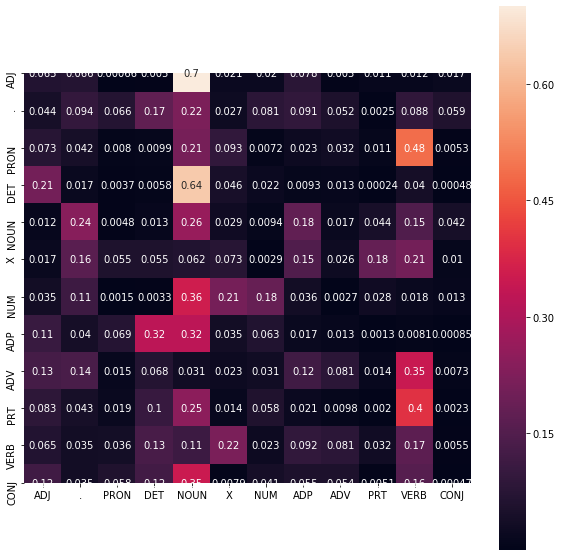

In [16]:
plt.figure(figsize=(10,10))
sns.heatmap(data=TransitionMatrix,annot=True,square=True)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [17]:
# Viterbi Heuristic
def VanillaViterbiPOSTagger(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = TransitionMatrix.loc['.', tag]
            else:
                transition_p = TransitionMatrix.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [18]:
test_tagged_words = [tup for sent in test_set for tup in sent]
test_vocab = [pair[0] for pair in test_tagged_words]
test_pos = [pair[1] for pair in test_tagged_words]
test_vocab_set = set(test_vocab)
test_pos_set = set(test_pos)

In [19]:
start = time.time()
tagged_seq = VanillaViterbiPOSTagger(test_vocab)
end = time.time()
difference = end-start

In [20]:
print(difference)

2207.3026139736176


#### Defining a function for getting the correct tag and incorrect tag sequence if true function returns correct tags if false function returns incorrect tags.

In [ ]:
def correcttag(pred,actual,bool):
    correct = []
# for correct tag
  if bool:
        for i in range(len(actual)):
            
            if pred[i]==actual[i]:
                correct.append(pred[i])
                
        return correct        
# for incorrect tag
  else:
    incorrect = []
    for i in range(len(actual)):
            if pred[i]!=actual[i]:
                incorrect.append(pred[i])
                correct.append(actual[i])
    return list(zip(incorrect,correct))

In [22]:
incorrect = correcttag(tagged_seq,test_tagged_words,False)
len(incorrect)

444

In [23]:
correct = correcttag(tagged_seq,test_tagged_words,True)
Accuracy = len(correct)/len(test_tagged_words)
print('Accuracy by normal Vanilla Viterbi',Accuracy*100)


Accuracy by normal Vanilla Viterbi 91.1377245508982


In [24]:
len(test_set)

196

In [25]:
#@title Default title text
tagged_seq

[('Meridian', 'NOUN'),
 ('National', 'NOUN'),
 ('Corp.', 'NOUN'),
 ('said', 'VERB'),
 ('0', 'X'),
 ('it', 'PRON'),
 ('sold', 'VERB'),
 ('750,000', 'NUM'),
 ('shares', 'NOUN'),
 ('of', 'ADP'),
 ('its', 'PRON'),
 ('common', 'ADJ'),
 ('stock', 'NOUN'),
 ('to', 'PRT'),
 ('the', 'DET'),
 ('McAlpine', 'NOUN'),
 ('family', 'NOUN'),
 ('interests', 'NOUN'),
 (',', '.'),
 ('for', 'ADP'),
 ('$', '.'),
 ('1', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 (',', '.'),
 ('or', 'CONJ'),
 ('$', '.'),
 ('1.35', 'NUM'),
 ('*U*', 'X'),
 ('a', 'DET'),
 ('share', 'NOUN'),
 ('.', '.'),
 ('All', 'DET'),
 ('four', 'NUM'),
 ('areas', 'NOUN'),
 ('had', 'VERB'),
 ('higher', 'ADJ'),
 ('revenue', 'NOUN'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('three', 'NUM'),
 ('months', 'NOUN'),
 ('ended', 'VERB'),
 ('Sept.', 'NOUN'),
 ('30', 'NUM'),
 ('.', '.'),
 ('That', 'DET'),
 ('settlement', 'NOUN'),
 ('was', 'VERB'),
 ('in', 'ADP'),
 ('April', 'NOUN'),
 ('1987', 'NUM'),
 ('.', '.'),
 ('The', 'DET'),
 ('management', 'NOUN'),
 ('

## POS tagging using modified Viterbi

## Method 1 Modifying the Viterbi
### Solve the problem of unknown words using Laplace smoothing by considering unknown words as 1 and divide it by total number of words in training  set.

In [48]:
def ViterbiUnknownwords(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = TransitionMatrix.loc['.', tag]
            else:
                transition_p = TransitionMatrix.loc[state[-1], tag]
                
            # compute emission and state probabilities
            if word not in train_vocab_set:
                emission_p = 1/len(train_bag)
                state_probability = emission_p * transition_p
                p.append(state_probability)
               
            else:
                              
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [27]:
start = time.time()
tagged_seq_unknown = ViterbiUnknownwords(test_vocab)
end = time.time()
difference = end-start

In [28]:
difference 


554.4009456634521

In [29]:
correct = correcttag(tagged_seq_unknown,test_tagged_words,True)
Accuracy = len(correct)/len(test_tagged_words)
print('Accuracy by  Vanilla Viterbi unknown words',Accuracy)

Accuracy by  Vanilla Viterbi unknown words 0.9389221556886228


In [30]:
incorrect = correcttag(tagged_seq,test_tagged_words,False)
incorrect

[(('about', 'ADP'), ('about', 'ADV')),
 (('most', 'ADV'), ('most', 'ADJ')),
 (('nominal', 'NUM'), ('nominal', 'ADJ')),
 (('gain', 'NOUN'), ('gain', 'VERB')),
 (('*-115', 'NUM'), ('*-115', 'X')),
 (('unlike', 'ADP'), ('unlike', 'ADJ')),
 (('built-from-kit', 'NUM'), ('built-from-kit', 'ADJ')),
 (('Altair', 'NUM'), ('Altair', 'NOUN')),
 (('Sol', 'NUM'), ('Sol', 'NOUN')),
 (('IMSAI', 'NUM'), ('IMSAI', 'NOUN')),
 (('keyboards', 'NUM'), ('keyboards', 'NOUN')),
 (('store', 'NOUN'), ('store', 'VERB')),
 (('AN', 'NUM'), ('AN', 'DET')),
 (('EXCHANGE', 'NUM'), ('EXCHANGE', 'NOUN')),
 (('change', 'VERB'), ('change', 'NOUN')),
 (('advertising', 'VERB'), ('advertising', 'NOUN')),
 (('more', 'ADV'), ('more', 'ADJ')),
 (('Yields', 'NUM'), ('Yields', 'NOUN')),
 (('slide', 'NOUN'), ('slide', 'VERB')),
 (('further', 'ADV'), ('further', 'ADJ')),
 (('declines', 'VERB'), ('declines', 'NOUN')),
 (('advisory', 'NUM'), ('advisory', 'NOUN')),
 (('parallel', 'VERB'), ('parallel', 'ADJ')),
 (('CTBS', 'NUM'), ('CT

In [31]:

Counter([pair[1][1] for pair in incorrect])

Counter({'ADJ': 95,
         'ADP': 2,
         'ADV': 26,
         'DET': 15,
         'NOUN': 197,
         'NUM': 1,
         'PRT': 3,
         'VERB': 94,
         'X': 11})

In [33]:
[(x,y) for x,y in incorrect if y[1]=='NOUN' or y[1]=='ADJ' ]

[(('most', 'ADV'), ('most', 'ADJ')),
 (('nominal', 'NUM'), ('nominal', 'ADJ')),
 (('unlike', 'ADP'), ('unlike', 'ADJ')),
 (('built-from-kit', 'NUM'), ('built-from-kit', 'ADJ')),
 (('Altair', 'NUM'), ('Altair', 'NOUN')),
 (('Sol', 'NUM'), ('Sol', 'NOUN')),
 (('IMSAI', 'NUM'), ('IMSAI', 'NOUN')),
 (('keyboards', 'NUM'), ('keyboards', 'NOUN')),
 (('EXCHANGE', 'NUM'), ('EXCHANGE', 'NOUN')),
 (('change', 'VERB'), ('change', 'NOUN')),
 (('advertising', 'VERB'), ('advertising', 'NOUN')),
 (('more', 'ADV'), ('more', 'ADJ')),
 (('Yields', 'NUM'), ('Yields', 'NOUN')),
 (('further', 'ADV'), ('further', 'ADJ')),
 (('declines', 'VERB'), ('declines', 'NOUN')),
 (('advisory', 'NUM'), ('advisory', 'NOUN')),
 (('parallel', 'VERB'), ('parallel', 'ADJ')),
 (('CTBS', 'NUM'), ('CTBS', 'NOUN')),
 (('Sidak', 'NUM'), ('Sidak', 'NOUN')),
 (('day-care', 'NUM'), ('day-care', 'ADJ')),
 (('Maytag', 'NUM'), ('Maytag', 'NOUN')),
 (('lesser', 'NUM'), ('lesser', 'ADJ')),
 (('knowns', 'NUM'), ('knowns', 'NOUN')),
 (('T

In [34]:
print(len(set([x[1] for sent in nltk_data for x in  sent])),set([x[1] for sent in nltk_data for x in  sent]))

12 {'NUM', '.', 'DET', 'ADJ', 'PRON', 'VERB', 'X', 'ADV', 'PRT', 'CONJ', 'ADP', 'NOUN'}


In [35]:
print(len(set([x[1] for sent in train_set for x in  sent])),set([x[1] for sent in train_set for x in  sent]))

12 {'NUM', '.', 'ADJ', 'PRON', 'VERB', 'ADV', 'X', 'PRT', 'NOUN', 'CONJ', 'ADP', 'DET'}


### From above we can see that Noun and ADJ are misclassified so lets try to tag them correctly using rule based tagger.

## Method 2
###Rule Based RegexpTagger

In [36]:
# specify patterns for tagging
# example from the NLTK book
patterns = [
    (r'.*ing$', 'VERB'),              
    (r'.*ed$', 'VERB'),               
    (r'.*es$', 'VERB'),               
    
    (r'.*able$', 'ADJ'), 
    (r'.*\-.*(\-.*)?$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
    
    (r'.*ly$','ADV'),

                  
    (r'.*\'s$', 'NOUN'),              
    (r'.*s$', 'NOUN'),                
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), 
    (r'.*', 'NOUN')                   
]

In [37]:
rule_based_tagger = nltk.RegexpTagger(patterns)

In [39]:
r = 'contionouly'
z=rule_based_tagger.tag([r])
z[0][1]


'ADV'

In [40]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

lexicon_tagger.evaluate(test_set)

0.9479041916167664

In [41]:
bigram_tagger = nltk.BigramTagger(train_set,backoff=lexicon_tagger)
bigram_tagger.evaluate(test_set)

0.9538922155688623

In [42]:
Trigram_tagger = nltk.TrigramTagger(train_set,backoff=bigram_tagger)
bigram_tagger.evaluate(test_set)

0.9538922155688623

In [43]:
rule_based_tagger.tag(['day-care','Akki'])

[('day-care', 'ADJ'), ('Akki', 'NOUN')]

## Creating a modified Viterbi and using BigramRule based tagger for unknown words backed by unigram and backed by Rule based tagger

In [47]:
def ViterbiBigramRule(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
      
        if word not in train_vocab_set:
            state_probability = bigram_tagger.tag([word])
            state.append(state_probability[0][1])
                  
               
        else:
        #initialise list of probability column for a given observation
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = TransitionMatrix.loc['.', tag]
           
                else:
                    transition_p = TransitionMatrix.loc[state[-1], tag]
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)  
        

               
    return list(zip(words, state))

In [45]:
viterbi_BigramRule_tagged_seq = ViterbiBigramRule(test_vocab)

In [46]:
correct = correcttag(viterbi_BigramRule_tagged_seq,test_tagged_words,True)
Accuracy = len(correct)/len(test_tagged_words)
print('Accuracy by Bigram Viterbi unknown',Accuracy*100)

Accuracy by Bigram Viterbi unknown 95.249500998004


#### Evaluating tagging accuracy on Sample test file given


1.   List item
2.   List item



In [50]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [51]:
file = open('/content/drive/My Drive/ML AI CASE STUDY WITH PCA/NLP/Test_sentences.txt')
text = file.read()
test_sent = sent_tokenize(text)
file.close()

In [52]:
test_tokenized_sents = [word_tokenize(sent) for sent in test_sent]
test_corpus_pos_tags = nltk.pos_tag_sents(test_tokenized_sents, tagset = 'universal')
test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [53]:
test_tokenized_sents

[['Android',
  'is',
  'a',
  'mobile',
  'operating',
  'system',
  'developed',
  'by',
  'Google',
  '.'],
 ['Android',
  'has',
  'been',
  'the',
  'best-selling',
  'OS',
  'worldwide',
  'on',
  'smartphones',
  'since',
  '2011',
  'and',
  'on',
  'tablets',
  'since',
  '2013',
  '.'],
 ['Google',
  'and',
  'Twitter',
  'made',
  'a',
  'deal',
  'in',
  '2015',
  'that',
  'gave',
  'Google',
  'access',
  'to',
  'Twitter',
  "'s",
  'firehose',
  '.'],
 ['Twitter',
  'is',
  'an',
  'online',
  'news',
  'and',
  'social',
  'networking',
  'service',
  'on',
  'which',
  'users',
  'post',
  'and',
  'interact',
  'with',
  'messages',
  'known',
  'as',
  'tweets',
  '.'],
 ['Before',
  'entering',
  'politics',
  ',',
  'Donald',
  'Trump',
  'was',
  'a',
  'domineering',
  'businessman',
  'and',
  'a',
  'television',
  'personality',
  '.'],
 ['The',
  '2018',
  'FIFA',
  'World',
  'Cup',
  'is',
  'the',
  '21st',
  'FIFA',
  'World',
  'Cup',
  ',',
  'an',
  'i

In [57]:
actual_test_tag = [x for sent in test_corpus_pos_tags for x in sent]

In [54]:
final_test = [x for sent in test_tokenized_sents for x in sent]

In [61]:
vanilla_tagged_seq = VanillaViterbiPOSTagger(final_test)

In [62]:
correct = correcttag(vanilla_tagged_seq,actual_test_tag,True)
VanillaAccuracy = len(correct)/len(actual_test_tag)
print('Accuracy by normal Vanilla Viterbi algorithm',VanillaAccuracy*100)

Accuracy by normal Vanilla Viterbi algorithm 79.00552486187846


In [63]:
Viterbi_Unknown_tagged_seq = ViterbiUnknownwords(final_test)

In [67]:
correct = correcttag(Viterbi_Unknown_tagged_seq,actual_test_tag,True)
ViterbiUnknown_Accuracy = len(correct)/len(actual_test_tag)
print('Accuracy by Modified laplace smooth Viterbi algorithm',ViterbiUnknown_Accuracy*100)

Accuracy by Modified laplace smooth Viterbi algorithm 89.50276243093923


In [65]:
ViterbiBigram_tagged_seq = ViterbiBigramRule(final_test)

In [68]:
correct = correcttag(ViterbiBigram_tagged_seq,actual_test_tag,True)
ViterbiBigram_Accuracy = len(correct)/len(actual_test_tag)
print('Accuracy by Viterbi Bigram algorithm',ViterbiBigram_Accuracy*100)

Accuracy by Viterbi Bigram algorithm 92.26519337016575


In [79]:

correct = correcttag(bigram_tagger.tag(final_test),actual_test_tag,True)
RegexpRule_Accuracy = len(correct)/len(actual_test_tag)
print('Accuracy by RegexpRule ',RegexpRule_Accuracy*100)


Accuracy by RegexpRule  91.16022099447514


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [80]:
compare_accuracy_df = [['Vanilla Viterbi', VanillaAccuracy*100], 
                  ['Viterbi Unknown', ViterbiUnknown_Accuracy*100], 
                  ['ViterbiBigram_tagger', ViterbiBigram_Accuracy*100]]
compare_accuracy_df  =  pd.DataFrame(compare_accuracy_df,columns=['Different Techniques','Accuracy'])
compare_accuracy_df       

,Different Techniques,Accuracy
0,Vanilla Viterbi,79.005525
1,Viterbi Unknown,89.502762
2,ViterbiBigram_tagger,92.265193


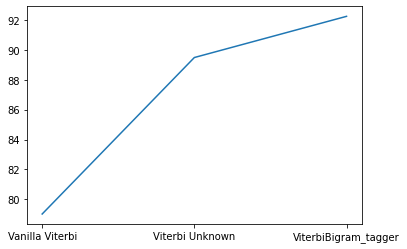

In [86]:
plt.plot('Different Techniques','Accuracy',data=compare_accuracy_df)

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [98]:
compare_tags = [[x[0],x[1],x[2],x[3]] for x in zip(actual_test_tag,vanilla_tagged_seq,Viterbi_Unknown_tagged_seq,ViterbiBigram_tagged_seq) if x[0]!=x[1] and (x[1]==x[2] or x[2]==x[3])]

In [101]:
compare_tags

[[('Android', 'NOUN'),
  ('Android', 'NUM'),
  ('Android', 'NOUN'),
  ('Android', 'NOUN')],
 [('Google', 'NOUN'),
  ('Google', 'NUM'),
  ('Google', 'NOUN'),
  ('Google', 'NOUN')],
 [('Android', 'NOUN'),
  ('Android', 'NUM'),
  ('Android', 'NOUN'),
  ('Android', 'NOUN')],
 [('OS', 'NOUN'), ('OS', 'NUM'), ('OS', 'NOUN'), ('OS', 'NOUN')],
 [('worldwide', 'NOUN'),
  ('worldwide', 'NUM'),
  ('worldwide', 'NOUN'),
  ('worldwide', 'NOUN')],
 [('Google', 'NOUN'),
  ('Google', 'NUM'),
  ('Google', 'NOUN'),
  ('Google', 'NOUN')],
 [('Twitter', 'NOUN'),
  ('Twitter', 'NUM'),
  ('Twitter', 'NOUN'),
  ('Twitter', 'NOUN')],
 [('that', 'DET'), ('that', 'ADP'), ('that', 'ADP'), ('that', 'ADP')],
 [('Twitter', 'NOUN'),
  ('Twitter', 'NUM'),
  ('Twitter', 'NOUN'),
  ('Twitter', 'NOUN')],
 [('online', 'ADJ'),
  ('online', 'NUM'),
  ('online', 'NOUN'),
  ('online', 'NOUN')],
 [('interact', 'NOUN'),
  ('interact', 'NUM'),
  ('interact', 'NOUN'),
  ('interact', 'NOUN')],
 [('tweets', 'NOUN'),
  ('tweets', '

In [99]:
final_check = pd.DataFrame(compare_tags,columns=['Actual_tags','VanillaViterbi','ViterbiUnknown','ViterbiBigram'])

#### Tags incorrectly tagged by Vanilla Viterbi and later got corrected by Modified Viterbi

In [100]:
final_check

,Actual_tags,VanillaViterbi,ViterbiUnknown,ViterbiBigram
0,"(Android, NOUN)","(Android, NUM)","(Android, NOUN)","(Android, NOUN)"
1,"(Google, NOUN)","(Google, NUM)","(Google, NOUN)","(Google, NOUN)"
2,"(Android, NOUN)","(Android, NUM)","(Android, NOUN)","(Android, NOUN)"
3,"(OS, NOUN)","(OS, NUM)","(OS, NOUN)","(OS, NOUN)"
4,"(worldwide, NOUN)","(worldwide, NUM)","(worldwide, NOUN)","(worldwide, NOUN)"
5,"(Google, NOUN)","(Google, NUM)","(Google, NOUN)","(Google, NOUN)"
6,"(Twitter, NOUN)","(Twitter, NUM)","(Twitter, NOUN)","(Twitter, NOUN)"
7,"(that, DET)","(that, ADP)","(that, ADP)","(that, ADP)"
8,"(Twitter, NOUN)","(Twitter, NUM)","(Twitter, NOUN)","(Twitter, NOUN)"
9,"(online, ADJ)","(online, NUM)","(online, NOUN)","(online, NOUN)"


#### From above we can see that Android,Google,OS,Worldwide which are NOUN were incorrectly classified as NUM by Vanilla Viterbi which were then corrected by Modified Viterbi for Unknown words and BigramViterbi as NOUN
